# UCDP dataset filtering

This notebook we use the information about the dataset that we got from the exploratory analysis to determine the conflicts that would be the most interesting for our purposes.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set_style('whitegrid')

%matplotlib inline

parsed_ucdp_dataset = '../data/parsed/parsed_ucdp.csv'
ucdp_df = pd.read_csv(parsed_ucdp_dataset, index_col='index', encoding='utf-8', compression='gzip')

As explained in the exploratory analysis for this dataset, the variables are the following:
* Year
* Type
    1. State-Based Violence
    2. Non-State Violence
    3. One-Sided Violence
* Country
* Date start
* Date end
* Casualties

In [2]:
def filter_ucdp(ucdp_df, type_conflict=1, number_casualties='low',
    classification_casualties=1, year=2016,
    n_conflicts_per_country=30, consider_all_conflicts=1):
    """ Returns a filtered dataframe in the ucdp_df format
    INPUT:
        type_conflict: Type of conflict (1,2 or 3)
        
        number_casualties: Number of casualties ('low', 'high')
        
        classification_casualties: How to determine if #casualties is low or high
            1 is what we considered when doing the exploratory analysis
            3 divides creates two groups with approx. equal #conflicts each
            
        year: Year that we want to keep
        
        n_conflicts_per_country: Keep the conflicts from countries with a lower #conflicts.
            If 0, then all conflicts are kept and the next variable is ignored.
        
        consider_all_conflicts: if n_conflicts_per_country>0, choose if filtering by:
            n. of conflicts of the type considered (0)
            n. of conflicts of the year considered (1)
            n. of total #conflicts (2)
    """
    filtered_year_df = ucdp_df[ucdp_df['Year'] == year]
    filtered_df = filtered_year_df[filtered_year_df['Type'] == type_conflict]
    if number_casualties == 'low':
        result_df = filtered_df[filtered_df['Casualties'] <= classification_casualties]
    else:
        result_df = filtered_df[filtered_df['Casualties'] > classification_casualties]
    if n_conflicts_per_country:
        if consider_all_conflicts == 0:
            conflicts_per_country = result_df.groupby('Country').count()['Year']
        elif consider_all_conflicts == 1:
            conflicts_per_country = filtered_year_df.groupby('Country').count()['Year']
        else:
            conflicts_per_country = ucdp_df.groupby('Country').count()['Year']
        countries_kept = list(conflicts_per_country[conflicts_per_country < n_conflicts_per_country].index)
        result_df = result_df[result_df['Country'].isin(countries_kept)]
    return result_df

In [3]:
filtered_ucdp_df = filter_ucdp(ucdp_df, type_conflict=3,
    number_casualties='high', classification_casualties=0,
    year=2016, n_conflicts_per_country=4, consider_all_conflicts=0)

#### Lastly, look at the kept conflicts
We are also interested in the number of conflicts and countries, since we would need enough different countries.

In [4]:
print('Number of conflicts: {}'.format(len(filtered_ucdp_df)))
print('Number of countries: {}'.format(len(filtered_ucdp_df['Country'].unique())))
print('List of countries: {}'.format(filtered_ucdp_df['Country'].unique()))

Number of conflicts: 30
Number of countries: 18
List of countries: ['YE' 'TD' 'ML' 'FR' 'EG' 'MZ' 'AO' 'CI' 'LB' 'IL' 'RU' 'DE' 'MX' 'CO' 'SA'
 'PE' 'BF' 'BE']


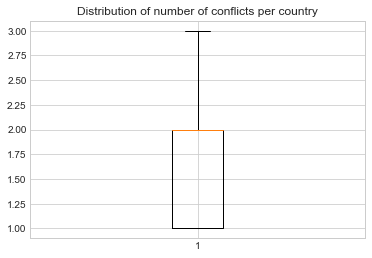

In [5]:
plt.boxplot(filtered_ucdp_df.groupby('Country').count()['Year'])
plt.title('Distribution of number of conflicts per country')
plt.show()

Lastly, we can save the filtered file.

In [6]:
# Save to csv file
filtered_ucdp_df = filtered_ucdp_df.reset_index()
filtered_ucdp_df.to_csv(parsed_ucdp_dataset, encoding='utf-8', index=False, compression='gzip')